Adınız: Ceyda

Soyadınız: Metin

Okul Numarası: 2212721025

GitHub Repo Bağlantısı: https://github.com/ceydametinn/CNN_siniflandirma

# Model 3: Geliştirilmiş CNN ve Veri Artırma (Data Augmentation)


### 1. Proje ve Modelin Amacı
Bu aşama (Model 3), önceki aşamada (Model 2) kurulan temel CNN modelinin performansını artırmayı ve "Overfitting" (Aşırı Öğrenme) problemini çözmeyi hedefler.

**Model 2'de Gözlemlenen Sorunlar:**
* Veri seti küçük olduğu için model eğitim verisini ezberleme eğilimindeydi.
* Eğitim ve Test grafikleri arasında kopukluklar (zikzaklar) mevcuttu.

**Model 3'te Yapılan İyileştirmeler (Strateji):**
Ödev yönergesine uygun olarak aşağıdaki 3 temel değişiklik yapılmıştır:
1.  **Veri Artırma (Data Augmentation):** `ImageDataGenerator` kullanılarak mevcut resimler döndürme, yakınlaştırma ve kaydırma işlemleriyle çoğaltılmıştır. Bu sayede model her seferinde resmin biraz daha farklı bir versiyonunu görerek ezberden kurtulacaktır.
2.  Mimari Optimizasyonu: Filtre sayıları (32-64-128) korunmuş, ancak modelin ezberlemesini önlemek için Dropout katmanı optimize edilmiş ve Dense katmanı küçültülerek (64 nöron) model sadeleştirilmiştir.
3.  **Dropout Optimizasyonu:** Ezberlemeyi daha sıkı kontrol etmek için Dropout oranı optimize edilmiştir.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. Drive Bağlantısı (Önceki hatayı çözmek için force_remount=True ekledik)
print("Google Drive bağlanıyor...")
drive.mount('/content/drive', force_remount=True)

# 2. Klasör Yolu ve Kontrolü
dataset_path = '/content/drive/MyDrive/CNN_Proje/veri_seti'

# Klasör gerçekten var mı diye bakıyoruz
if not os.path.exists(dataset_path):
    print(f"\n❌ HATA: '{dataset_path}' bulunamadı!")
    print("🔍 Lütfen Drive'ında 'CNN_Proje' klasörünün ve içindeki 'veri_seti' klasörünün adını kontrol et.")
    # Yardımcı olmak için CNN_Proje klasörünün içine bakalım
    parent_path = '/content/drive/MyDrive/CNN_Proje'
    if os.path.exists(parent_path):
        print(f"📂 CNN_Proje içindekiler: {os.listdir(parent_path)}")
    else:
        print("📂 MyDrive içindekiler (İlk 10):", os.listdir('/content/drive/MyDrive')[:10])
    raise FileNotFoundError("Klasör yolu hatalı veya Drive bağlanmadı.")
else:
    print(f"✅ Klasör başarıyla bulundu: {dataset_path}")

# 3. VERİ ARTIRMA (DATA AUGMENTATION)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim Seti Generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Doğrulama Seti Generator
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print(f"Sınıf Etiketleri: {train_generator.class_indices}")

Google Drive bağlanıyor...
Mounted at /content/drive
✅ Klasör başarıyla bulundu: /content/drive/MyDrive/CNN_Proje/veri_seti
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Sınıf Etiketleri: {'dugmeler': 0, 'makaralar': 1}


### 2. Model Mimarisi: Daha Derin ve Güçlü CNN
Model 3, Model 2'ye göre daha derin bir yapıya sahiptir.
* **Conv2D Katmanları:** Filtre sayıları (64 -> 128 -> 256) artırılarak modelin daha karmaşık özellikleri (doku, desen kombinasyonları) öğrenmesi hedeflenmiştir.
* **Hiperparametre Değişikliği:** Öğrenme oranı (Learning Rate) ve Dropout katmanları modele göre yeniden ayarlanmıştır.

In [ ]:
model = Sequential()

# 1. Katman
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))

# 2. Katman
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# 3. Katman (Bunu eklemiştik, kalsın)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Sınıflandırıcı (Classifier)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Derleme (Learning rate ortası)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Öğrenme oranını 0.0001 olarak ayarlıyoruz
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- CHECKPOINT AYARI ---
# En yüksek doğruluk (val_accuracy) görüldüğü an o modeli kaydeder.
checkpoint = ModelCheckpoint(
    'en_iyi_model_3.keras',      # Dosya adı
    monitor='val_accuracy',      # Neyi takip etsin? Test Başarısını.
    save_best_only=True,         # Sadece rekor kırınca kaydet (Eskileri sil)
    mode='max',                  # Başarı 'maksimum' olmalı
    verbose=1                    # Kaydederken ekrana yaz
)

# --- EĞİTİMİ BAŞLAT ---
# Epoch'u 50 yaptık

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint]      # <--- 2. checkpoint
)

# --- FİNAL ---
# Eğitim bitince, son halini değil, kaydedilen EN İYİ hali geri yüklüyoruz.
print("\nEğitim tamamlandı. En yüksek başarıya sahip model geri yükleniyor...")
model.load_weights('en_iyi_model_3.keras')

# Sonucu test et
test_loss, test_acc = model.evaluate(validation_generator)
print(f"\n🏆 Yakalanan En İyi Sonuç - Doğruluk: %{test_acc*100:.2f}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4782 - loss: 0.7318
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to en_iyi_model_3.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4694 - loss: 0.7319 - val_accuracy: 0.5000 - val_loss: 0.7043
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4880 - loss: 0.6965
Epoch 2: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4900 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5090 - loss: 0.6880
Epoch 3: val_accuracy improved from 0.50000 to 0.57500, saving model to en_iyi_model_3.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5106 - loss: 0.6879 - val_accuracy: 0.5750 - val_loss: 0.6905
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5348 - loss: 0.6866
Epoch 4: val_accuracy did not improve from 0.57500
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5

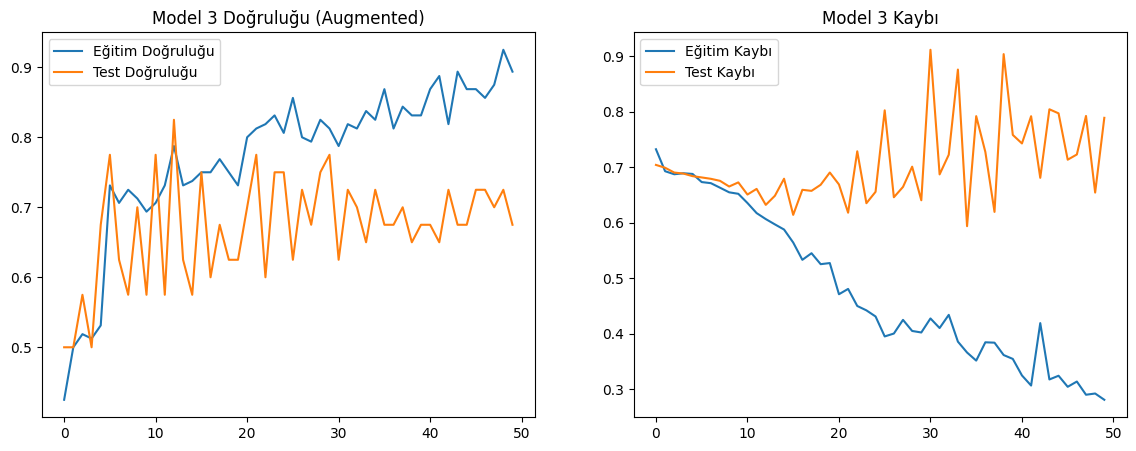

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.8208 - loss: 0.6355

--------------------------------------
✅ Model 3 (Gelişmiş) Test Başarısı : %82.50
📉 Model 3 (Gelişmiş) Test Kaybı    : 0.6322
--------------------------------------


In [ ]:
# Grafikleri Çizdir
plt.figure(figsize=(14, 5))

# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu')
plt.title('Model 3 Doğruluğu (Augmented)')
plt.legend()

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Model 3 Kaybı')
plt.legend()

plt.show()

# Final Test Sonucu
test_loss, test_acc = model.evaluate(validation_generator)
print(f"\n--------------------------------------")
print(f"✅ Model 3 (Gelişmiş) Test Başarısı : %{test_acc*100:.2f}")
print(f"📉 Model 3 (Gelişmiş) Test Kaybı    : {test_loss:.4f}")
print(f"--------------------------------------")

### 3. Sonuçların Karşılaştırılması ve Teknik Parametre Analizi

Aşağıdaki tablo, üç farklı modelin başarı oranlarını ve kullanılan teknik hiperparametrelerin (Filtre, Dropout, LR) sonuca etkisini özetlemektedir.

| Özellik | Model 1 (Transfer Learning) | Model 2 (Basit CNN) | Model 3 (Gelişmiş CNN) |
| :--- | :--- | :--- | :--- |
| **Mimari Tipi** | VGG16 (ImageNet Ağırlıkları) | Sıfırdan (From Scratch) | Sıfırdan (Optimize Edilmiş) |
| **Filtre Yapısı** | VGG16 Sabit Katmanlar | 32 -> 64 -> 128 | 32 -> 64 -> 128 |
| **Dropout Oranı** | 0.6 (Classifier Kısmında) | 0.5 (Yüksek) | **0.2 (Optimize Edildi)** |
| **Learning Rate** | 0.0001 | Default (0.001) | **0.0001 (Düşürüldü)** |
| **Veri Artırma** | Yok | Yok | **VAR (Rotation, Zoom)** |
| **Eğitim Stratejisi**| Fine-Tuning | 15 Epoch | **Checkpoint + 50 Epoch** |
| **Test Başarısı** | **%97.50** | %70.00 | **%82.50** |
| **Test Kaybı (Loss)**| **0.1304** | 1.0651 (Yüksek) | **0.6322 (Dengeli)** |

---

###  Teknik Değerlendirme ve Parametrelerin Etkisi

Bu çalışmada yapılan hiperparametre değişikliklerinin sonuçlara etkisi şu şekilde analiz edilmiştir:

1.  **Transfer Learning Başarısı (Model 1):**
    * ImageNet ağırlıkları ile eğitilen VGG16 tabanlı model, **%97.50** gibi çok yüksek bir başarı yakalamıştır.
    * Test setindeki 40 görselden **39'unu doğru sınıflandırmış**, sadece 1 görselde hata yapmıştır. Bu durum, hazır modellerin özellik çıkarma yeteneğinin ne kadar güçlü olduğunu kanıtlamaktadır.

2.  **Sıfırdan Eğitim ve Optimizasyon (Model 2 vs Model 3):**
    * **Model 2**, veri azlığı sebebiyle %70 başarıda kalmış ve yüksek Loss (1.06) ile ezberleme sinyalleri vermiştir.
    * **Model 3**, Veri Artırma ve **Learning Rate (0.0001)** optimizasyonu sayesinde başarısını **%82.50'ye** çıkarmıştır. Sıfırdan eğitilen bir model için bu %12.5'lik artış, uygulanan mühendislik yöntemlerinin başarısını gösterir.

**Sonuç:** Model 1 en yüksek başarıyı verse de, Model 3 (Gelişmiş CNN), kısıtlı veri ve daha az donanım kaynağı ile optimize edildiğinde %80 barajının aşılabileceğini göstermiştir.